# Plan Rescheduling

This notebook shows how plans can be rescheduled (activity start times and duration changed). For this example we change some example plans in order to optimise each plan score. We use a scoring function based on the MATSim Charypar-Nagel score.

In [1]:
from pam.activity import Activity, Leg
from pam.core import Person
from pam.scoring import CharyparNagelPlanScorer
from pam.utils import minutes_to_datetime as mtdt
from pam.variables import END_OF_DAY

%matplotlib inline

## Step 1

Configure the CharyparNagelPlanScorer. We use the Charypar-Nagel score to be consistent with MATSim, but you mighty decide to create your own.

In [2]:
default_config = {
    "mUM": 1,
    "utilityOfLineSwitch": -1,
    "performing": 6,
    "waiting": -1,
    "waitingPt": -2,
    "lateArrival": -18,
    "earlyDeparture": -6,
    "work": {
        "typicalDuration": "08:30:00",
        "openingTime": "06:00:00",
        "closingTime": "20:00:00",
        "latestStartTime": "09:30:00",
        "earliestEndTime": "16:00:00",
        "minimalDuration": "08:00:00",
    },
    "home": {
        "typicalDuration": "09:00:00",
        "minimalDuration": "06:00:00",
        "earliestEndTime": "06:00:00",
    },
    "shop": {
        "openingTime": "06:00:00",
        "closingTime": "20:00:00",
        "typicalDuration": "00:30:00",
        "minimalDuration": "00:30:00",
    },
    "car": {
        "constant": -5,
        "dailyMonetaryConstant": -0,
        "dailyUtilityConstant": -0,
        "marginalUtilityOfDistance": -0,
        "marginalUtilityOfTravelling": -0,
        "monetaryDistanceRate": -0.0005,
    },
    "walk": {"marginalUtilityOfTravelling": -12},
}

config = {subpop: default_config for subpop in ["default"]}

scorer = CharyparNagelPlanScorer(cnfg=config)

## Step 2

Load or create some activity plans. In this example we create three persons plans, all with the same sequence of activities and same travel times, but with different activity start times and durations.

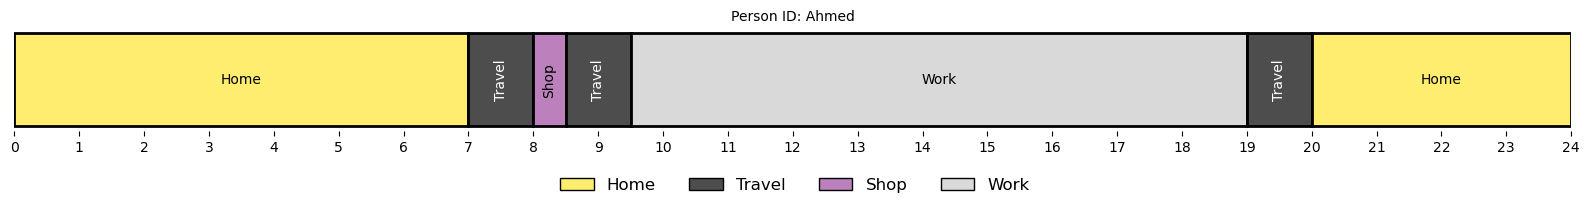

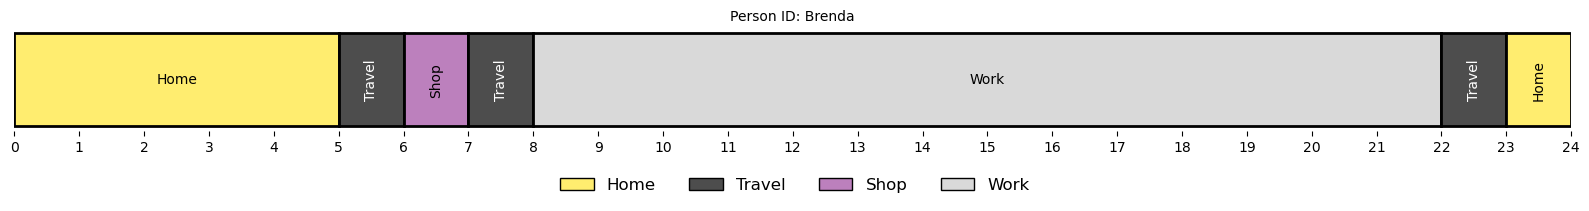

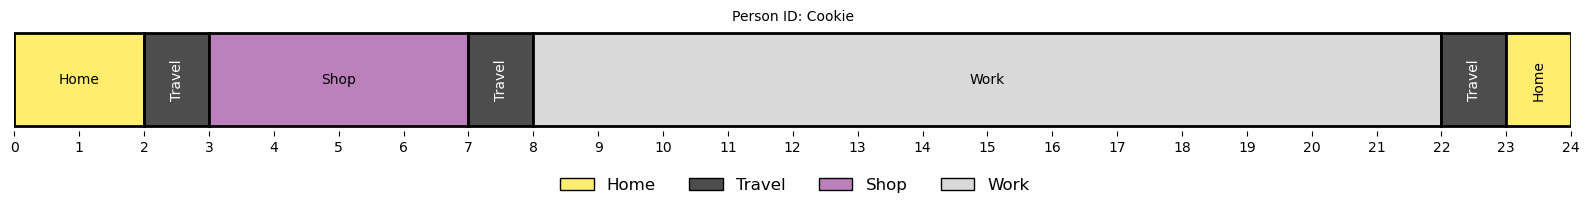

In [3]:
personA = Person("Ahmed", attributes={"age": 20, "subpopulation": "default"})
personA.plan.day = [
    Activity(act="home", area=1, start_time=mtdt(0), end_time=mtdt(420)),
    Leg(mode="car", start_time=mtdt(420), end_time=mtdt(480), distance=1000),
    Activity(act="shop", area=2, start_time=mtdt(480), end_time=mtdt(510)),
    Leg(mode="walk", start_time=mtdt(510), end_time=mtdt(570), distance=1000),
    Activity(act="work", area=3, start_time=mtdt(570), end_time=mtdt(1140)),
    Leg(mode="car", start_time=mtdt(1140), end_time=mtdt(1200), distance=1000),
    Activity(act="home", area=1, start_time=mtdt(1200), end_time=END_OF_DAY),
]

personB = Person("Brenda", attributes={"age": 20, "subpopulation": "default"})
personB.plan.day = [
    Activity(act="home", area=1, start_time=mtdt(0), end_time=mtdt(300)),
    Leg(mode="car", start_time=mtdt(300), end_time=mtdt(360), distance=1000),
    Activity(act="shop", area=2, start_time=mtdt(360), end_time=mtdt(420)),
    Leg(mode="walk", start_time=mtdt(420), end_time=mtdt(480), distance=1000),
    Activity(act="work", area=3, start_time=mtdt(480), end_time=mtdt(1320)),
    Leg(mode="car", start_time=mtdt(1320), end_time=mtdt(1380), distance=1000),
    Activity(act="home", area=1, start_time=mtdt(1380), end_time=END_OF_DAY),
]

personC = Person("Cookie", attributes={"age": 20, "subpopulation": "default"})
personC.plan.day = [
    Activity(act="home", area=1, start_time=mtdt(0), end_time=mtdt(120)),
    Leg(mode="car", start_time=mtdt(120), end_time=mtdt(180), distance=1000),
    Activity(act="shop", area=2, start_time=mtdt(180), end_time=mtdt(420)),
    Leg(mode="walk", start_time=mtdt(420), end_time=mtdt(480), distance=1000),
    Activity(act="work", area=3, start_time=mtdt(480), end_time=mtdt(1320)),
    Leg(mode="car", start_time=mtdt(1320), end_time=mtdt(1380), distance=1000),
    Activity(act="home", area=1, start_time=mtdt(1380), end_time=END_OF_DAY),
]

personA.plot()
personB.plot()
personC.plot()

## Step 3

Score our plans. Note that for our example Brenda has the highest score.

In [4]:
print(f"{personA.pid}'s score = {scorer.score_person(personA)}")
print(f"{personB.pid}'s score = {scorer.score_person(personB)}")
print(f"{personC.pid}'s score = {scorer.score_person(personC)}")

Ahmed's score = 101.50872494557763
Brenda's score = 220.77119050471717
Cookie's score = 162.59537925482084


## Step 4

Seek to reschedule the plans to improve their scores. We do this with the optimisers from `pam.optimise`.

In [5]:
from pam.optimise import grid, random

In [6]:
plans = [personA.plan, personB.plan, personC.plan]

print("Random search optimisation:")
optimised_by_random = []
for plan in plans:
    optimised, _ = random.reschedule(
        plan, plans_scorer=scorer, config=config["default"], patience=5000
    )
    optimised_by_random.append(optimised)
print("Grid search optimisation:")
optimised_by_grid = []
for plan in plans:
    optimised, _ = grid.grid_search(
        plan, plans_scorer=scorer, config=config["default"], step=1800  # step size is in seconds
    )
    optimised_by_grid.append(optimised)

Random search optimisation:


Score improved from 101.50872494557763 to 216.04289233237552 in 5000 steps.


Failed to improve score from initial 220.77119050471717 in 5000 steps.


Score improved from 162.59537925482084 to 214.99751260850485 in 5000 steps.
Grid search optimisation:


Score improved from 101.50872494557763 to 242.61260211505845 using step size 1800s.


Score improved from 220.77119050471717 to 242.61260211505845 using step size 1800s.


Score improved from 162.59537925482084 to 242.61260211505845 using step size 1800s.


Note that the random search quality depends upon the level of patience and the grid search on the step size. Setting patience higher or using smaller grid steps may result in better scores but at the cost of more compute. We can think of better ways to implement these schedule optimisers, but we leave it as an exercise to the reader.

In this case we can see that the grid search finds a schedule with a short shopping trip at 7.30 and the 10 hours at work. For our example grid search finds the same optima for all, because the plans have the same activities, sequence, and trips.

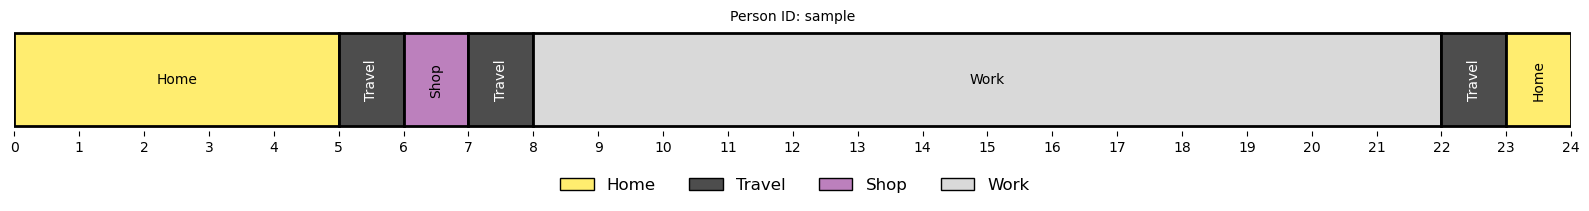

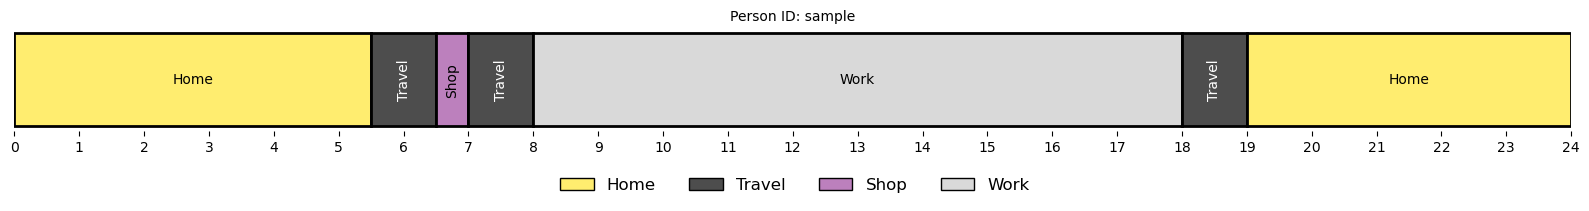

In [7]:
optimised_by_random[1].plot()
optimised_by_grid[1].plot()

## Considering Different Scorers

As an experiment lets make a small change to our config file and check the outcome:

Score improved from 102.4076882473681 to 244.0 using step size 1800s.


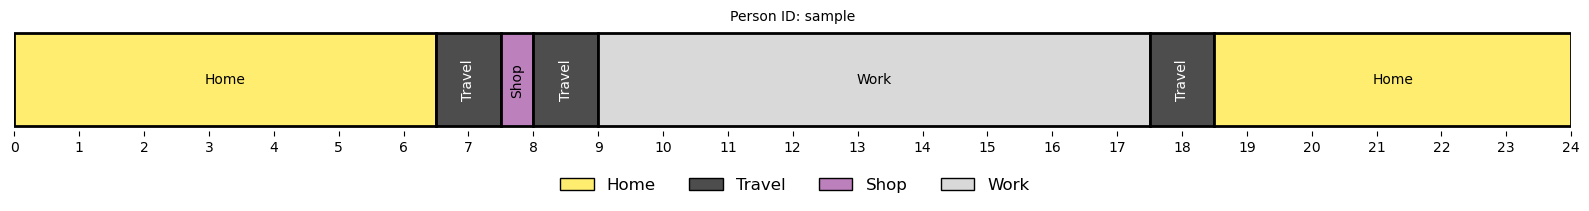

In [8]:
config["default"]["home"]["typicalDuration"] = "12:00:00"  # previously "09:00:00"
config["default"]["home"]["minimalDuration"] = "10:00:00"  # previously "06:00:00"
config["default"]["home"]["earliestEndTime"] = "07:00:00"  # previously "06:00:00"

scorer = CharyparNagelPlanScorer(cnfg=config)

optimised, _ = grid.grid_search(
    plans[0], plans_scorer=scorer, config=config["default"], step=1800  # step size is in seconds
)
optimised.plot()

By adjusting our scorer to value time at home more, we can see that the grid search has found a new schedule with later start time and shorter work duration. We can use this approach to refine our configuration to one that we prefer.

## Measuring Change

The planner.encode module supports endoding plans in a way that they can be quantitively compared. This might be used as a systematic way to identify plans that are "wrong" or not correctly scored. In the following example we use a one-hot encoding of plans to show which of our example plans changes most when resheduled using the grid search:

In [9]:
from pam.array import distance, encode

mapping = {"home": 0, "travel": 1, "shop": 2, "work": 3}  # activity type to column index map
# Example one-hot encoding:
encode.plan_to_one_hot(plans[0], mapping)

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [10]:
ranked = []
for name, plan, optimised in zip(["Ahmed", "Brenda", "Cookie"], plans, optimised_by_grid):
    plan_encoded = encode.plan_to_one_hot(plan, mapping, bin_size=900)
    optimised_encoded = encode.plan_to_one_hot(optimised, mapping, bin_size=900)
    difference = distance.accuracy(plan_encoded, optimised_encoded)
    ranked.append((name, difference))

ranked = sorted(ranked, key=lambda x: x[1], reverse=True)

for name, score in ranked:
    print(name, score)

Ahmed 0.7916666666666666
Brenda 0.75
Cookie 0.6041666666666666


Ahmed's plan has changed most. This could be interpretted as them having the "worst configuration".